<a href="https://colab.research.google.com/github/InzamanCareem/Customer-Telecom-Churn-Prediction/blob/main/Classification_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/Coursework/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [85]:
!pip install keras-tuner

# Import Libraries

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score
from keras_tuner.tuners import RandomSearch

# Read Dataset

In [164]:
df = pd.read_csv(dataset_path)
print(df.shape)

(7043, 21)


In [165]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Pre-processing

In [167]:
df.duplicated().sum()

np.int64(0)

In [89]:
df.drop("customerID", axis=1, inplace=True)

In [90]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_cols = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
                    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                    "Contract", "PaperlessBilling", "PaymentMethod"]
target_col = "Churn"

In [91]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [92]:
for cat in categorical_cols:
  df[cat] = df[cat].astype('category')

In [93]:
df["Churn"] = df["Churn"].astype('category')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [95]:
df.isna().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [96]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [97]:
df.isna().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [98]:
def remove_outliers(df, cols):
  for col in cols:
      Q1 = df[col].quantile(0.25)
      Q3 = df[col].quantile(0.75)
      IQR = Q3 - Q1

      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
  return df.reset_index(drop=True)

In [99]:
df = remove_outliers(df, numerical_cols)

In [145]:
df.shape

(7043, 20)

In [101]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [102]:
df["Churn"] = (df["Churn"] == "Yes").astype(int)

In [103]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10,8))
    plt.plot(fpr_dt, tpr_dt, color='orange', label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [104]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

# Splitting the data for Decision Tree Model

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [106]:
scaler = MinMaxScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [107]:
le = LabelEncoder()

for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# Building the Decision Tree Model

In [108]:
dtree = DecisionTreeClassifier()

dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [109]:
y_pred = dtree.predict(X_test)

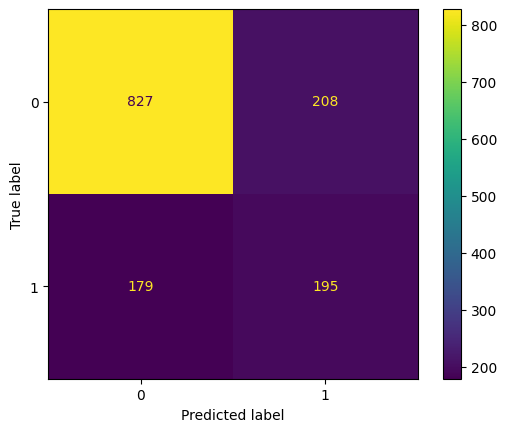

In [110]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=df["Churn"].unique())
disp.plot()
plt.show()

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1035
           1       0.48      0.52      0.50       374

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409



In [112]:
dot_data = tree.export_graphviz(dtree, out_file=None,
                     feature_names=df.columns[:-1],
                     class_names=[str(c) for c in df[df.columns[-1]].unique()],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [113]:
dt_probs = dtree.predict_proba(X_test)[:, 1]

In [114]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test,dt_probs)
roc_auc = auc(fpr_dt,tpr_dt)

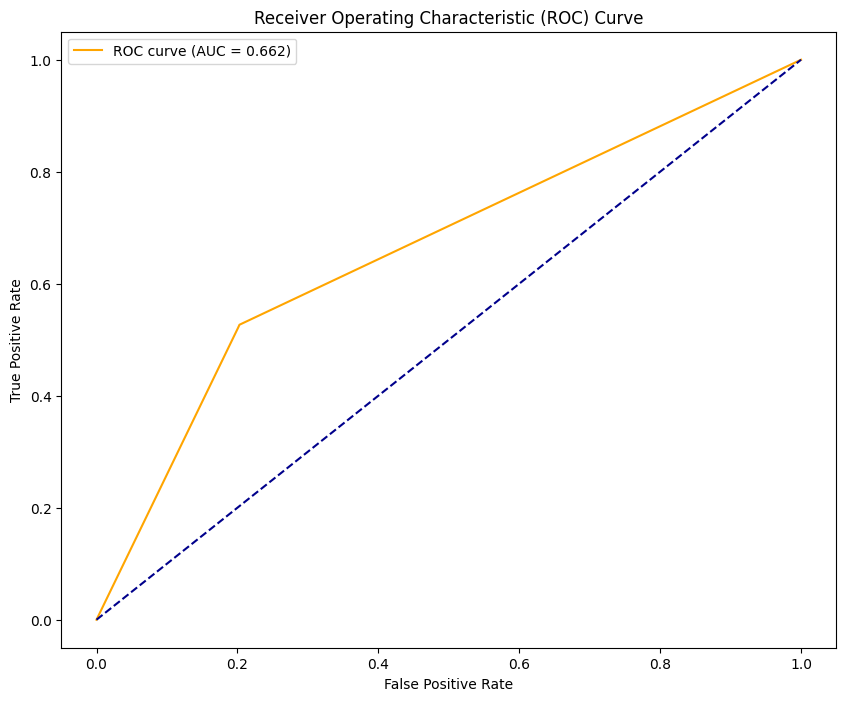

In [115]:
plot_roc_curve(fpr_dt,tpr_dt)

# Splitting the data for Neural Network Model

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [117]:
scaler = MinMaxScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [118]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train[categorical_cols])
X_test_encoded = ohe.transform(X_test[categorical_cols])

In [119]:
# Convert to DataFrame with proper column names
encoded_cols = ohe.get_feature_names_out(categorical_cols)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Drop original categorical columns and concatenate encoded columns
X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded)
X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded)

# Building the Neural Network Model

In [120]:
input_dim = X_train.shape[1]

In [125]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(input_dim, )),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(64, activation="tanh"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "binary_crossentropy"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7507 - binary_crossentropy: 0.4864 - loss: 0.4864 - val_accuracy: 0.7578 - val_binary_crossentropy: 0.4733 - val_loss: 0.4733
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7884 - binary_crossentropy: 0.4359 - loss: 0.4359 - val_accuracy: 0.7764 - val_binary_crossentropy: 0.4542 - val_loss: 0.4542
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8021 - binary_crossentropy: 0.4171 - loss: 0.4171 - val_accuracy: 0.7941 - val_binary_crossentropy: 0.4434 - val_loss: 0.4434
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8015 - binary_crossentropy: 0.4182 - loss: 0.4182 - val_accuracy: 0.7862 - val_binary_crossentropy: 0.4401 - val_loss: 0.4401
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8162 - binary_crossentropy: 0.4003 - loss: 0.4003 - val_accuracy: 0.7879 - val_binary_crossentropy: 0.4426 - val_loss: 0.4426
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━

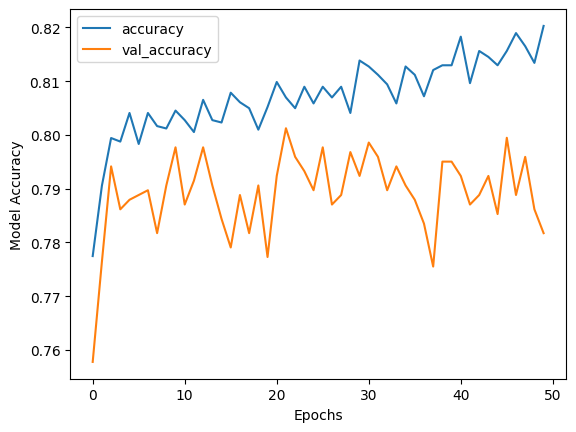

In [127]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.show()

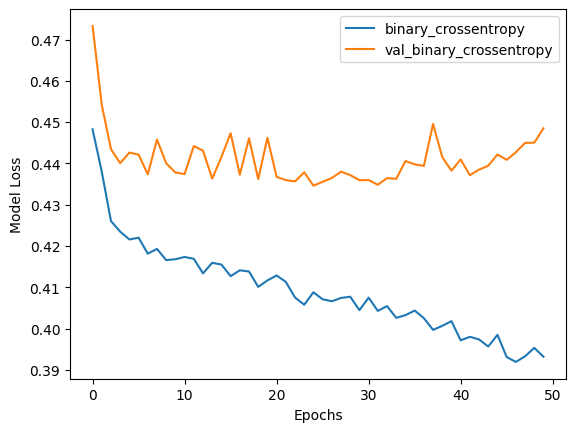

In [128]:
plt.plot(history.history["binary_crossentropy"], label="binary_crossentropy")
plt.plot(history.history["val_binary_crossentropy"], label="val_binary_crossentropy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Model Loss")
plt.show()

In [129]:
y_pred = np.round(model.predict(X_test))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


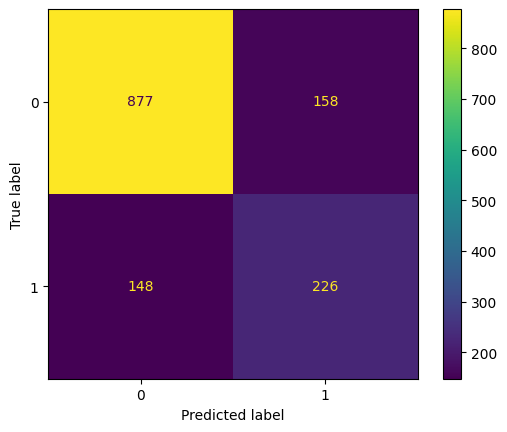

In [130]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=df["Churn"].unique())
disp.plot()
plt.show()

In [131]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1035
           1       0.59      0.60      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [132]:
nn_probs = model.predict(X_test).ravel()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


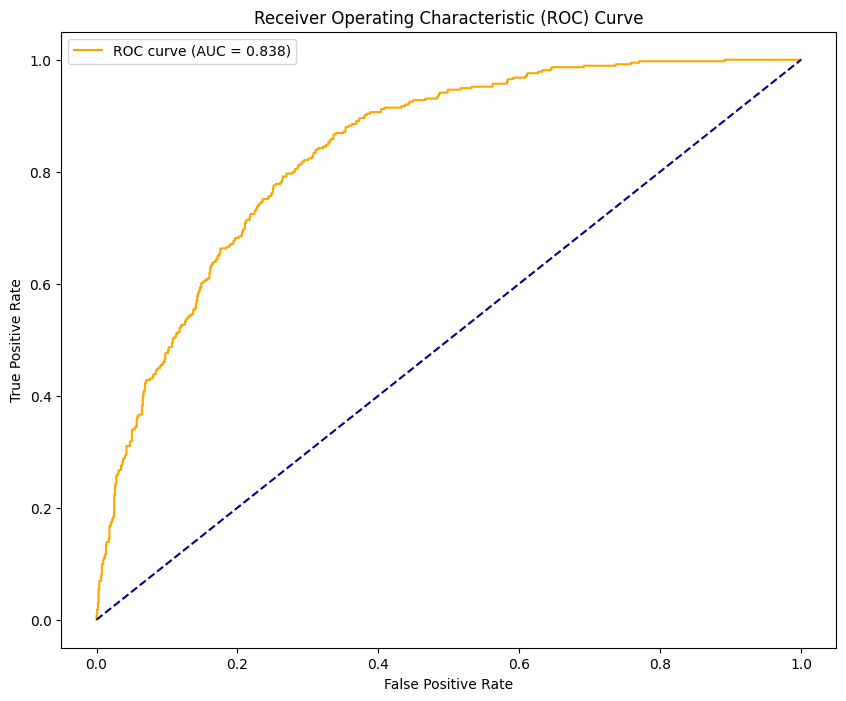

In [133]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, nn_probs)
roc_auc = auc(fpr_dt,tpr_dt)

plot_roc_curve(fpr_dt,tpr_dt)

# Hyperparameter Tuning using Grid Search for Decision Tree Model

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [135]:
scaler = MinMaxScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [136]:
le = LabelEncoder()

for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [137]:
dtree = DecisionTreeClassifier()

# Define parameter grid
param_grid = {
    'class_weight': [None, "balanced"],
    'criterion': ["gini", "entropy"],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

# Grid search with cross-validation
grid_search_dtree = GridSearchCV(dtree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_dtree.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc', verbose=2)

In [138]:
best_dtree = grid_search_dtree.best_estimator_
print("Best params:", grid_search_dtree.best_params_)
print("Best CV AUC:", grid_search_dtree.best_score_)

Best params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best CV AUC: 0.8313238247245396


In [139]:
y_pred = best_dtree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7849538679914834


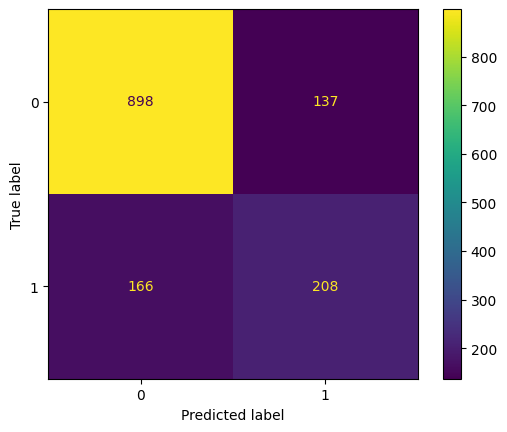

In [140]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.60      0.56      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [142]:
y_gs_dtree_probs = best_dtree.predict_proba(X_test)[:, 1]

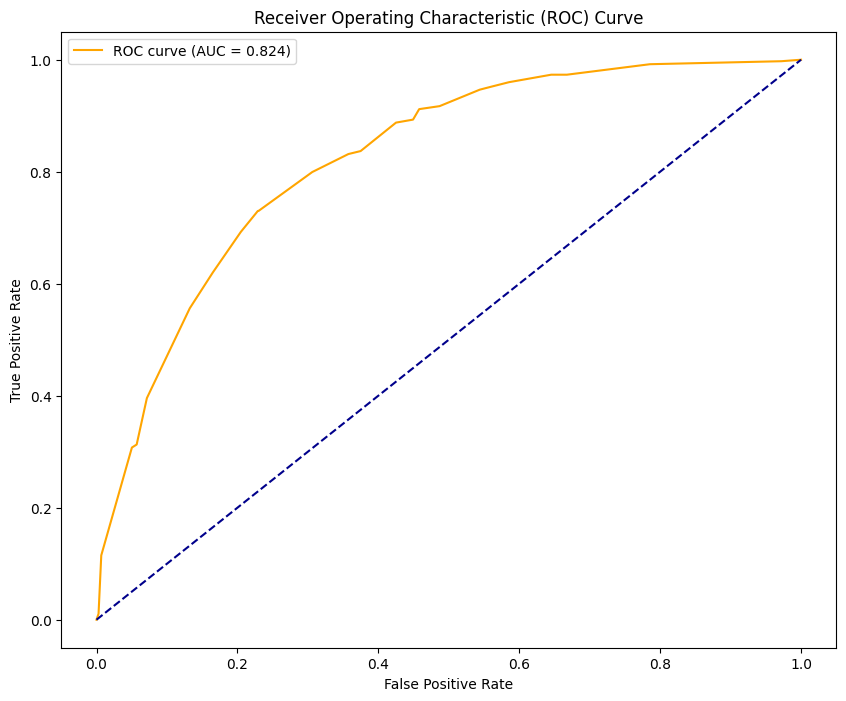

In [143]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_gs_dtree_probs)
roc_auc = auc(fpr_dt,tpr_dt)

plot_roc_curve(fpr_dt,tpr_dt)

# Hyperparameter Tuning using Random Search for Neural Network Model

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [147]:
scaler = MinMaxScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [148]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train[categorical_cols])
X_test_encoded = ohe.transform(X_test[categorical_cols])

In [149]:
# Convert to DataFrame with proper column names
encoded_cols = ohe.get_feature_names_out(categorical_cols)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Drop original categorical columns and concatenate encoded columns
X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded)
X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded)

In [157]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[1], )))
    model.add(tf.keras.layers.Dense(units=hp.Int('units', 16, 128, step=16), activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', 0.0, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='binary_crossentropy', metrics=['AUC'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_AUC',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='nn_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 20 Complete [00h 00m 26s]
val_AUC: 0.8266907930374146

Best val_AUC So Far: 0.8276809453964233
Total elapsed time: 00h 09m 28s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [158]:
y_pred = np.round(best_model.predict(X_test).ravel())
print("Accuracy:", accuracy_score(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7892122072391767


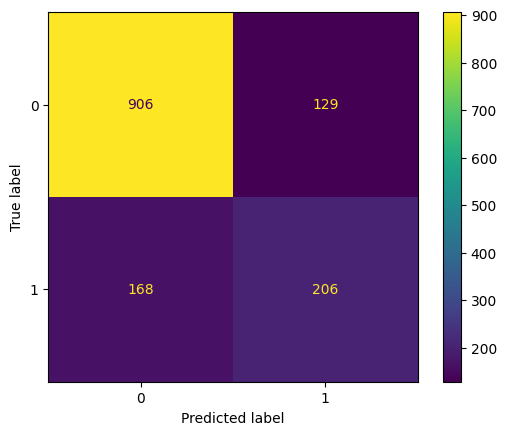

In [159]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



In [161]:
y_rs_nn_prob = best_model.predict(X_test).ravel()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


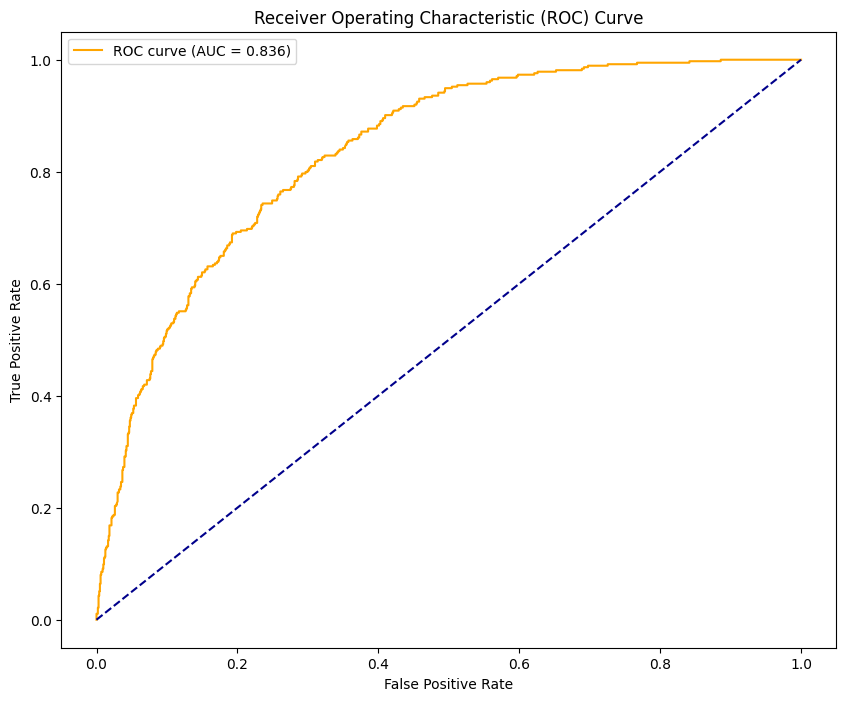

In [162]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_rs_nn_prob)
roc_auc = auc(fpr_dt,tpr_dt)

plot_roc_curve(fpr_dt,tpr_dt)